<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/1.1_strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code/Parameters
* Setup
    * needs
        * auth
        * gsheet auth
        * cfg_strava
* updates sheets
* Todo
    * low: error: location not found 

## Config

In [37]:
repo='https://github.com/avinashmane/colab.git'
CONFIG_FILE='config.yaml'

#clone report for colab
import yaml,os,sys
if not os.path.exists('./repo') and (os.name!='nt'):
    !git clone $repo repo
    sys.path.append('repo')   

#read config file

with open(CONFIG_FILE if os.name=='nt' 
          else f"repo/{CONFIG_FILE}","r+") as _c:
    cfg=yaml.load(_c,yaml.Loader)
for x in cfg['env'][os.name]: 
    os.environ[x]=cfg['env'][os.name][x]
    globals()[x]=cfg['env'][os.name][x]

#setup environment
if os.name=='nt':
    # LIB= r'c:\m\lib'
    # LOG= r'c:\m\social-media-automation'
    # AUTH= r'c:\i\auth'
    sys.path.append(LIB)
else:
    !apt update
    if not os.path.exists('drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    # LIB='/content/drive/MyDrive/m/lib'
    # LOG='/content/drive/MyDrive/m/lib'
    # AUTH='/content/drive/MyDrive/m/auth'
    if not os.path.exists('m'):
      !ln -sd '/content/drive/MyDrive/m/' m
    sys.path.append("repo/lib")
sys.path.append('lib')

In [2]:
import importlib
import utils
importlib.reload(utils)
utils.setup_env(cfg['packages'],cfg['modules'])

'Environment setup'

## Code

In [52]:
import yaml
from datetime import datetime
import os
from nerodia.browser import Browser
import nerodia
import re
import logging
from IPython.display import Image, Markdown
import pandas as pd

import utils

import socialmediasite 
importlib.reload(socialmediasite)
Strava=socialmediasite.Strava
SocialMediaSite=socialmediasite.SocialMediaSite


In [4]:
"reach gsheet"

import gsheets
Gsheet=gsheets.Gsheet


In [5]:
df_mc=Gsheet(cfg['sheets']['stravasync']['url']).getSheetDf(cfg['sheets']['stravasync']['tab'],start='A10')

# ssl=Gsheet('stravasync')
# df_mc

# Process
## Create headless

In [6]:
" Test Selenium headless"
if True:
    if os.name=='nt':
        b=Browser('chrome')
    else:
        
        # import sys
        # sys.path.insert(0,f'{DIR}/geckodriver')
        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    
    utils.setLogger(f"{LOG}/strava-automation.log")
    

2022-09-09 19:23:23:INFO:Logger file: c:/m/logging/strava-automation.log


In [53]:

strava=Strava(b,authFile=f'{AUTH}/auth.yaml',
              cfg=cfg,
              # cfgFile=f"{LIB}/cfg_strava.yaml",
              delay=.5)
strava.logGSheet = Gsheet(cfg['sheets']['StravaPromoLog']['url']).getSheetByTitle('StravaPromoLog')
strava.StravaMembers=df_mc.query('strava=="strava"').id.values

sessionGSheet = Gsheet(cfg['sheets']['StravaPromoLog']['url']).getSheetByTitle('SessionLog')

# A. Mileage Certificates

In [8]:
strava.login("mileage_league_strava")

In [9]:
certSheet=Gsheet(cfg['sheets']['certs']['url'])
certTab=certSheet.getSheetByTitle(cfg['sheets']['certs']['tab'])
df_cert=certTab.get_as_df().query("comment_text!='' and Activity==''"
                                   ).reset_index()
cols={x:df_cert.columns.get_loc(x)+1 for x in ['comment_ts','comment_text']}
# display(cols)
# merge
_df=df_cert.merge(df_mc[['Email','profile','strava']],on='Email')

c:\sw\python37\lib\site-packages\pygsheets\worksheet.py:1477: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')


In [10]:
_df['index 	CertType 	Email 	Milestone 	Name 	Date 	ID 	Team	comment_ts 	Activity 		profile 	strava'.split()]

,index,CertType,Email,Milestone,Name,Date,ID,Team,comment_ts,Activity,profile,strava
0,1174,RunDays,dmanojk2004@yahoo.co.in,150,Manoj Kulkarni,8/27/2022,1jLX5LtsxRgzQau5IZK7MM4k1-8RQ5r-S,P,,,,strava
1,1176,Everests,mahendra.kadam20@gmail.com,1,Mahendra Kadam,8/28/2022,1H3JT4iLwEZmOOKDN2PRMK_aym9XRV6PN,N,,,,strava
2,1177,Everests,manojhere@gmail.com,2,Manoj Vazarkar,8/28/2022,1RRS64qL9wlIBRR9ItfvL7FurU-Az3b5D,N,,,,strava
3,1178,CyclingDist,waliaunmesh@gmail.com,9000,Unmesh Ahluwalia,8/28/2022,15Bq99owHw1XHH2Ce0-vZWgSoh-0x7nYM,N,,,,strava
4,1179,Everests,aminsharp@gmail.com,3,Amin Shaikh,8/28/2022,101RC425MkDD7dYdskFEqGqMyVF4FihUS,A,,,,strava
...,...,...,...,...,...,...,...,...,...,...,...,...
67,1282,RunDist,amitkumar_nbq@yahoo.in,1000,AmiT KumaR,9/8/2022,1T6NzfwcgqUDRvKUCWMx8XmcjukyE_qJo,A,,,,strava
68,1284,Everests,premketan@gmail.com,1,Akhilesh choudhary,9/9/2022,1MI4x8ABjZJGKdfER9NipptjnNg80PxZG,A,,,,strava
69,1285,RunDays,snehalbafana75@gmail.com,150,Snehal Bafana,9/9/2022,1e8z-fZ61UNQf6R2HQVGh8j7J6CuM5gJ_,A,,,,strava
70,1287,RunDays,manish.u.singh@gmail.com,50,Manish Singh,9/9/2022,14uhfB8ns3Kp7uxAXm4X-vvUfmVyZHvwp,A,,,https://www.strava.com/athletes/37281233,strava


In [11]:
if False:
    from pprint import pprint as pp

    for i,cert in _df.query("strava=='strava'").iterrows():
        # print (cert['index'],cert.profile,cert.comment_text)

        try:

            if not cert.profile: 
                logging.warning(f"{cert.Row},{cert.Name},{cert.profile} : {cert['index']} no profle")
                continue
            b.goto(cert.profile)
            # url=f"https://www.strava.com/activities/{x['activity_id']}"
            certTab.update_values(crange=(cert.Row,cols['comment_ts']),
                             values=[[pd.Timestamp.now().isoformat(),cert.profile]])
            if True:
                commentEl=b.button(data_testid="comment_button")
                strava.postComment(commentEl,cert.comment_text)
                logging.info(f"{cert.Row},{cert.Name},{cert.profile} :{cert.comment_text}")

                # break
        except Exception as e:
            logging.error(f"{cert.Row},{cert.Name},{cert.profile} : {e!r} ")
            # raise Exception("Something went wrong while posting comment")
            continue


# B. Give likes on Club

### mileage_league_strava Feed Likes

2022-09-09 20:08:25:INFO:Logged in with mileage.league@gmail.com


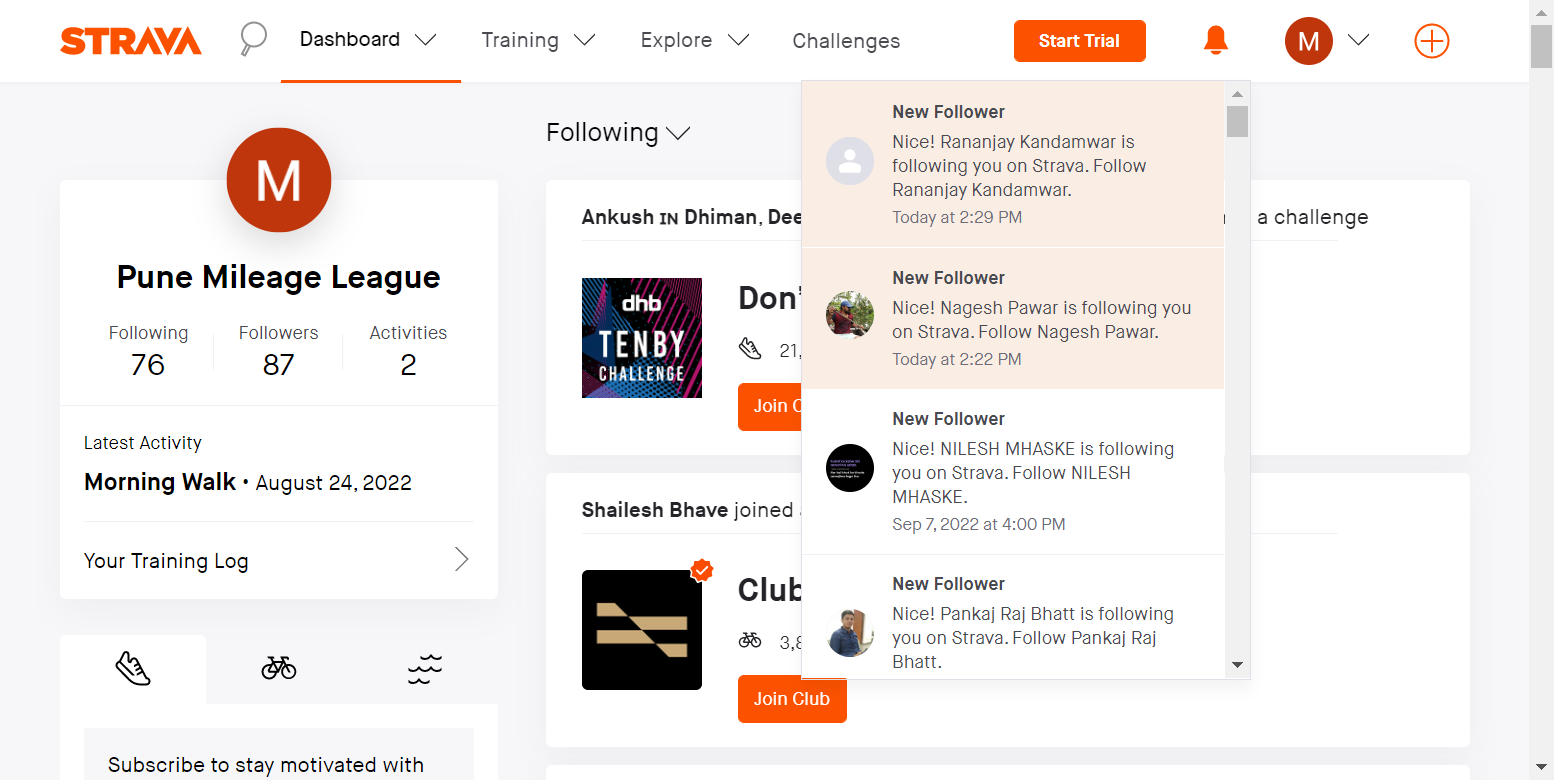

2022-09-09 20:08:30:INFO:Total number of cards on mileage_league_strava/Dashboard | Strava: 39


###  mileage_league_strava https://www.strava.com/clubs/mileageleague Club Likes

2022-09-09 20:08:36:INFO:Total number of cards on https://www.strava.com/clubs/mileageleague 'Atlanta, Georgia Club | Mileage League: 2022 in 2022 on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/pcmcrunners Club Likes

2022-09-09 20:08:42:INFO:Total number of cards on https://www.strava.com/clubs/pcmcrunners 'Pimpri-Chinchwad, Maharashtra, India Club | PCMCRunners on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/prettycoolmileagechallenge Club Likes

2022-09-09 20:08:48:INFO:Total number of cards on https://www.strava.com/clubs/prettycoolmileagechallenge 'India Club | Milage Challenge : 2022 in 2022 on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/pcmcbikers Club Likes

2022-09-09 20:08:55:INFO:Total number of cards on https://www.strava.com/clubs/pcmcbikers 'Pimpri-Chinchwad, Maharashtra, India Club | PCMC Tring Tring on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/punecycling Club Likes

2022-09-09 20:09:01:INFO:Total number of cards on https://www.strava.com/clubs/punecycling 'Pune, Maharashtra, India Club | Strava Pune Cycling on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/didyouruntoday Club Likes

2022-09-09 20:09:07:INFO:Total number of cards on https://www.strava.com/clubs/didyouruntoday 'Mumbai, Maharashtra, India Club | Did you run today on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/PuneWalkers Club Likes

2022-09-09 20:09:12:INFO:Total number of cards on https://www.strava.com/clubs/PuneWalkers 'Pune, Maharashtra, India Club | Pune Walkers on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/prettycoolmileagechallenge Club Likes

2022-09-09 20:09:19:INFO:Total number of cards on https://www.strava.com/clubs/prettycoolmileagechallenge 'India Club | Milage Challenge : 2022 in 2022 on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/mileageleague Club Likes

2022-09-09 20:09:26:INFO:Total number of cards on https://www.strava.com/clubs/mileageleague 'Atlanta, Georgia Club | Mileage League: 2022 in 2022 on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/weekendriderspune Club Likes

2022-09-09 20:09:32:INFO:Total number of cards on https://www.strava.com/clubs/weekendriderspune 'Pune, Maharashtra, India Club | WEEKEND CYCLE RIDES (PUNE) on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/cycleforpune Club Likes

2022-09-09 20:09:38:INFO:Total number of cards on https://www.strava.com/clubs/cycleforpune 'Pune, Maharashtra, India Club | Cycle For Pune on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/pcmcrunners Club Likes

2022-09-09 20:09:43:INFO:Total number of cards on https://www.strava.com/clubs/pcmcrunners 'Pimpri-Chinchwad, Maharashtra, India Club | PCMCRunners on Strava': 20
2022-09-09 20:09:47:INFO:Logged out


### avinash Feed Likes

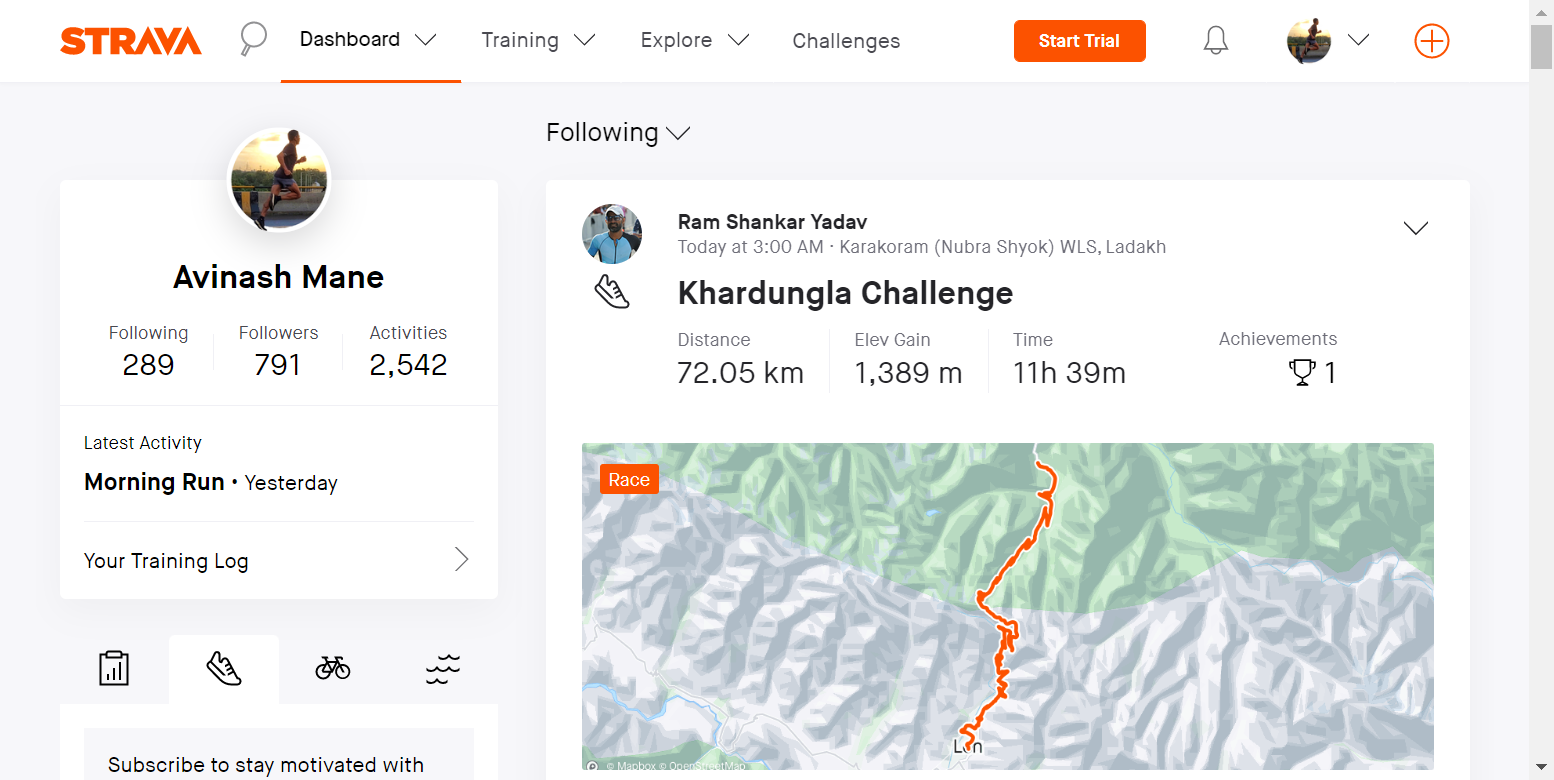

2022-09-09 20:10:00:INFO:Total number of cards on avinash/Dashboard | Strava: 40


###  avinash https://www.strava.com/clubs/delhirunnersgroup Club Likes

2022-09-09 20:11:16:INFO:Total number of cards on https://www.strava.com/clubs/delhirunnersgroup 'New Delhi, Delhi, India Club | DRG Delhi Runners Group on Strava': 20


2022-09-09 20:12:13:INFO:Logged out
2022-09-09 20:12:13:INFO:All Groups done


In [54]:
for _user,_config in {
                    "mileage_league_strava":"mileage_league_strava",
                    "avinash":"avinash",
                    # "strava_pcmcrunners":"strava_pcmcrunners"
                    }.items():
    display(Markdown(f"### {_user} Feed Likes"))
    strava.login(_user)
    display(Image(b.screenshot.png()))
    strava.scrolldown(4) 
    _cards=len(b.divs(class_name=re.compile('^Card')))
    logging.info(f"Total number of cards on {_user}/{strava.browser.title}: {_cards}")
    ret=strava.giveKudos()
    #SessionLog :   Date	SessionType	User	Feed	cards	actions
    sessionGSheet.append_table([[pd.Timestamp.now().isoformat(),"Kudos",_user,'feed',_cards,ret['tot_kudos']]])
    
    for club in strava.cfg['strava'][_config]['clubs']:
      display(Markdown(f"###  {_user} {club} Club Likes"))
      strava.goto(f"{club}/recent_activity")
      _cards=len(b.divs(class_name=re.compile('^Card')))
      logging.info(f"Total number of cards on {club} '{strava.browser.title}': {_cards}")
      ret=strava.giveKudos()
      #SessionLog :   Date	SessionType	User	Feed	cards	actions
      sessionGSheet.append_table([[pd.Timestamp.now().isoformat(),"Kudos",_user,club,_cards,ret['tot_kudos']]])
    strava.logout()
logging.info(f"All Groups done")    

In [55]:

# import json
# b.driver.execute_script("window.open();")
# b.driver.switch_to.window(b.driver.window_handles[1])
# b.goto('https://www.strava.com/activities/7756480538')
# actData=json.loads(b.div(data_react_class="ADPKudosAndComments").data_react_props)
# pp(actData)
# b.driver.close()

# # back to the main window
# b.driver.switch_to.window(strava.main_window)

{'username': 'mileage.league@gmail.com', 'password': '#fitness4life'}

In [ ]:
# switch to the new window which is second in window_handles array

# open successfully and close


strava.cfg[strava.siteType][strava.login]

# End

In [ ]:
"""
new members

list of people with messages sent
for feed 
    if location is [selected] and 
    not a member of challenge and
    not been sent message before
        add up the activity
        
for each such name
    check start lat/long for the activity
        post a comment
        add name to message sent
"""

In [28]:
yaml.safe_load("""test:
     · Pune City, Maharashtra [' · Pune City, Maharashtra', ' Â· Haveli, India', ' Â· Mulshi, Maharashtra', ' Â· Mulshi, India']""")

{'test': "· Pune City, Maharashtra [' · Pune City, Maharashtra', ' Â· Haveli, India', ' Â· Mulshi, Maharashtra', ' Â· Mulshi, India']"}

# test

In [ ]:
if False:
    driver=b.driver

    # save main_window
    main_window = driver.current_window_handle

    # obtain url of gmail on the home page of Google
    addr =b.link(data_testid="activity_name").href

    # open new blank tab
    driver.execute_script("window.open();")

    # switch to the new window which is second in window_handles array
    driver.switch_to.window(driver.window_handles[1])

    # open successfully and close
    driver.get(addr)
    driver.close()

    # back to the main window
    driver.switch_to.window(main_window)
    # driver.get(addr)

In [ ]:
# {x.text[:30]:x.link().href for x in b.divs(data_testid="activity_entry_container")}

In [ ]:
# _log=Gsheet('https://docs.google.com/spreadsheets/d/14a8u53o0V6jKwP1nxk0334jvKsRnW6J5hKzcaQAwUbw/edit#gid=179675201')
# _logss=_log.getSheetByTitle('StravaPromoLog')
# _df=_logss.get_as_df()

# # _df.applymap(lambda x: ",".join(x),index=1)
# _df.to_csv('c:/temp/promolog.log',
#            mode="a",header=False,
#            index=None)
# display(_df.shape)
# if _df.shape[0]:
#     _logss.delete_rows(2,_df.shape[0])

In [ ]:

display(extrDict(b.driver.__dict__,['script*','session_id','chrome1']))
pp(b.driver.__dict__)
# dpath.util.search??

In [ ]:
# _logss.clear(start='A2',end=None)

In [ ]:
from string import Template

def _f():
    a=1
    b=2
    print("{}['a'] {b}".format(1,2))
    
_f()

In [ ]:
[*{'a':1}]